In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action = "ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


Time 피처의 경우는 데이터 생성 관련한 작업용 속성으로 큰 의미가 없어 제거한다. 

Amount 피처는 신용카드 거래 금액을 의미, 

Class는 레이블로서 0의 경우 정상, 1의 경우 사기 거래이다. 

In [5]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

결측치가 없다는 것을 확인하고, 레이블인 Class 열만 int 형 이고, 나머지는 float형임을 알 수 있다. 

In [6]:
from sklearn.model_selection import train_test_split

#인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

C:\anaconda3\envs\machine_learning\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
C:\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


get_preprocessed_df함수는 결국 Time 칼럼을 삭제하는 함수이다.

In [7]:
#사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수 
def get_train_test_dataset(df= None):
    #인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환 
    df_copy = get_preprocessed_df(df)
    #DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들 
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    #train_test_split() 으로 학습과 테스트 데이터 분할 , stratify = y_target으로 Stratified 기반 분할 
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
    #학습과 테스트 데이터 세트 반환 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

학습 데이터와 테스트 데이터를 분할하는 함수이다. 이때, 데이터의 분포가 불균형하기 때문에 서로 들어가는 비율을 맞추는 

Stratify 파라미터를 설정해주어 분포도를 서로 동일하게 만들어준다. 

In [8]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts() / y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts() / y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np


def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    
    print('정확도 : {0:.4f} , 정밀도 : {1:.4f} , 재현율 : {2:.4f} \
    F1 : {3:.4f}, AUC : {4:.4f}, '.format(accuracy, precision, recall, f1, roc_auc))

3장에서 생성한 get_clf_eval() 함수 사용 전 정의를 해주어야 한다.

### 로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능의 변화를 볼 것이다.

로지스틱 회귀부터 

In [10]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

#3장에서 사용한 get_clf_eval() 함수를 이용해 평가를 수행한다.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   58    90]]
정확도 : 0.9992 , 정밀도 : 0.8738 , 재현율 : 0.6081     F1 : 0.7171, AUC : 0.8040, 


복습 > predict_proba는 predict의 경우에 예측 레이블을 반환하는 반면, 

predict_proba는 0일 확률과 1일 확률을 나타내어 주므로, 뒤에 [:, 1]은 

모든 데이터들의 레이블을 1로 예측할 확률을 뽑는 것이다 .

**앞으로 모델을 변경해 학습/예측/평가할 것이므로 이에 대한 함수를 작성한다.**

In [11]:
# 인자로 사이킷런의 Estimator객체와 학습/ 테스트 데이터 세트를 입력 받아서 학습/예측 / 평가 수행
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train= None, tgt_test= None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

여기에서 다루는 데이터는 매우 불균형한 레이블을 가지고 있으므로, LGBMClassifier의 boost_from_average 파라미터를 False로 지정해 주어야 한다. 

In [12]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average=False)

get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

C:\anaconda3\envs\machine_learning\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


오차 행렬
[[85289     6]
 [   36   112]]
정확도 : 0.9995 , 정밀도 : 0.9492 , 재현율 : 0.7568     F1 : 0.8421, AUC : 0.8783, 


전반적으로 예측 성능이 로지스틱 회귀를 웃도는 것을 확인할 수 있다. 

## 데이터 분포도 변환 후 모델 학습/예측/평가

일단 중요 피처 값의 분포도를 살펴보자. 

로지스틱회귀는 선형 모델이다. 

대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다. 

Amount 피처를 기준으로 한번 살펴보자.

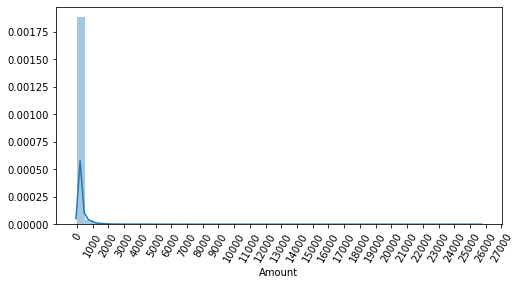

In [13]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df['Amount'])

카드 사용금액이 1000불 이하인 데이터가 대부분이며, 27000까지 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있다. 

이 Amount 피처를 표준 정규 분포의 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정해 볼 것이다. 

In [14]:
from sklearn.preprocessing import StandardScaler

#사이킷 런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변화하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    #변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력 
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제 
    df_copy.drop(['Time', "Amount"], axis = 1, inplace = True)
    return df_copy

In [15]:
#A mount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992 , 정밀도 : 0.8654 , 재현율 : 0.6081     F1 : 0.7143, AUC : 0.8040, 
### LightGBM 예측 성능 ###


C:\anaconda3\envs\machine_learning\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


오차 행렬
[[85289     6]
 [   36   112]]
정확도 : 0.9995 , 정밀도 : 0.9492 , 재현율 : 0.7568     F1 : 0.8421, AUC : 0.8783, 


In [16]:
def get_preprocessed_df(df =None):
    df_copy = df.copy()
    #넘파이의 log1p() 를 이용해 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis =1, inplace  = True)
    return df_copy

In [17]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   58    90]]
정확도 : 0.9992 , 정밀도 : 0.8824 , 재현율 : 0.6081     F1 : 0.7200, AUC : 0.8040, 
### LightGBM 예측 성능 ###


C:\anaconda3\envs\machine_learning\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


오차 행렬
[[85290     5]
 [   35   113]]
정확도 : 0.9995 , 정밀도 : 0.9576 , 재현율 : 0.7635     F1 : 0.8496, AUC : 0.8817, 


책과는 AUC 부분이 차이가 있다. 하지만, 오차행렬을 보면 예측한 결과는 동일하므로 일단 넘어가도록 한다. 

또한, LightGBM에서 해당 수치가 조금 증가했다는 것을 알 수 있다. 

## 이상치 데이터 제거 후 모델 학습 / 예측 / 평가

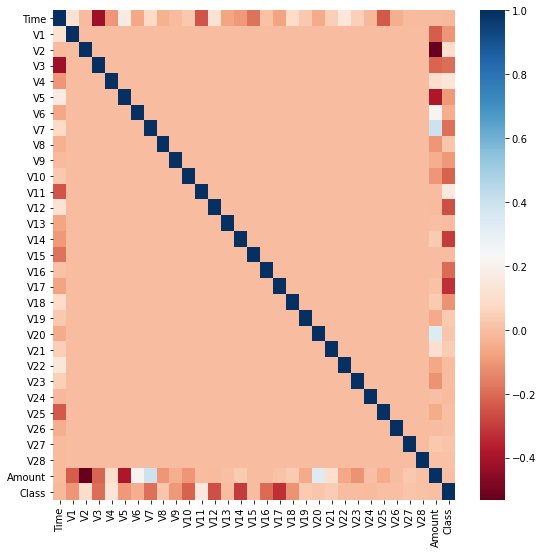

In [18]:
import seaborn as sns

plt.figure(figsize = (9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

해당 데이터가 많은 피처가 있을 경우에는 모든 이상치를 삭제하는 것은 비효율 적이다. 


따라서, 레이블과 가장 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 좋다. 


이것을 위해 DataFrame의 corr()을 이용해 각 피처별로 상관도를 구한 뒤 heatmap을 통해서 시각화

## Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17이다. 

음의 상관관계라고 생각을 하기 보다는 Class 피처와 상관관계가 있다. (빨간색 or 파란색이 진할수록)라고 생각을 하는게 이해하기 쉽다.

get_outlier() 함수는 인자로 DataFrame와 칼럼 명을 입력 받고,

함수 내에서 percentile() 을 이용해 1/4분위와 3/4분위를 구하고, 이에 기반해 IQR을 계산

In [22]:
def get_outlier(df=None, column=None, weight = 1.5):
    #fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4분위 지점을 np.percentile로 구함.
    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    #IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud < lowest_val) | (fraud>highest_val)].index
    return outlier_index

In [23]:
outlier_index = get_outlier(card_df, column = 'V14', weight = 1.5)
print('이상치 데이터 인덱스 : ', outlier_index)

이상치 데이터 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


이것 또한, get_processed_df() 함수에 추가 

In [25]:
#get_processed_df() 를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis= 1, inplace = True)
    #이상치 데이터 삭제하는 로직 추가 
    outlier_index = get_outlier(df=df_copy, column = 'V14', weight = 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True)
    return df_copy


X_train, X_test, y_train, y_test =get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   48    98]]
정확도 : 0.9993 , 정밀도 : 0.8829 , 재현율 : 0.6712     F1 : 0.7626, AUC : 0.8355, 
### LightGBM 예측 성능 ###


C:\anaconda3\envs\machine_learning\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


오차 행렬
[[85291     4]
 [   25   121]]
정확도 : 0.9997 , 정밀도 : 0.9680 , 재현율 : 0.8288     F1 : 0.8930, AUC : 0.9144, 


## SMOTE 오버 샘플링 적용

In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state =0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/ 레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n' , pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/ 레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
 1    199020
0    199020
dtype: int64


In [29]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[82932  2363]
 [   11   135]]
정확도 : 0.9722 , 정밀도 : 0.0540 , 재현율 : 0.9247     F1 : 0.1021, AUC : 0.9485, 


로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링 된 데이터로 학습을 진행하면, 

재현율은 크게 증가한 반면 정밀도가 5.4%로 급격하게 감소하는 것을 알 수 있다. 

이것의 이유는 **너무 많은 Class = 1의 데이터를 학습하면서 예측에 지나치게 Class = 1로 적용해 정밀도가 떨어진다.**

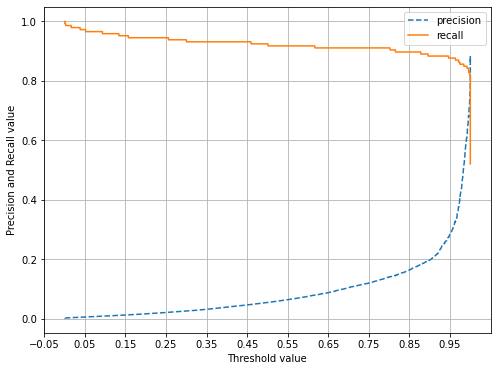

In [32]:
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(y_test, pred_proba_c1) : 
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 threshold 값으로,  Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시 
    plt.figure(figsize = (8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    #threshold 값 X축의 Scale을 0.1 eksdnlfh qusrud 
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    #x축, y축 label과 legend, 그리고 grid 설정 
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

위 그래프를 보면 0.99의 임계값을 기준으로 정밀도와 재현율이 상반된 현상, 그리고 아주 극단적인 현상을 보이는 것을 알 수 있다. 

임계값을 0.99정도로 하면 되지 않나? 라는 생각이 들수도 있지만, 

임계값의 민감도가 너무 심해 올바를 예측 모델이 생성되지 못하다. 

In [33]:
lgbm_clf = LGBMClassifier(n_estimators= 1000, num_leaves = 64, n_jobs = -1, boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

C:\anaconda3\envs\machine_learning\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


오차 행렬
[[85286     9]
 [   22   124]]
정확도 : 0.9996 , 정밀도 : 0.9323 , 재현율 : 0.8493     F1 : 0.8889, AUC : 0.9246, 


재현율은 증가했짐나, 정밀도는 감소한 것을 볼 수 있다. 

**SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적인 경우이다.**

좋은 SMOTE 패키지 일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출수 있다. 